In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree
import h5pyd
import requests
import os
import sys
import calendar
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl

In [2]:
path = '/home/vboxuser/Data/Solar_Data/Cebu_Sun_Data'

files = os.listdir(path)
files.sort()
for i in files:
    print(i)

5356928_10.42_123.71_2016.csv
5356928_10.42_123.71_2017.csv
5356928_10.42_123.71_2018.csv
5356928_10.42_123.71_2019.csv
5356928_10.42_123.71_2020.csv


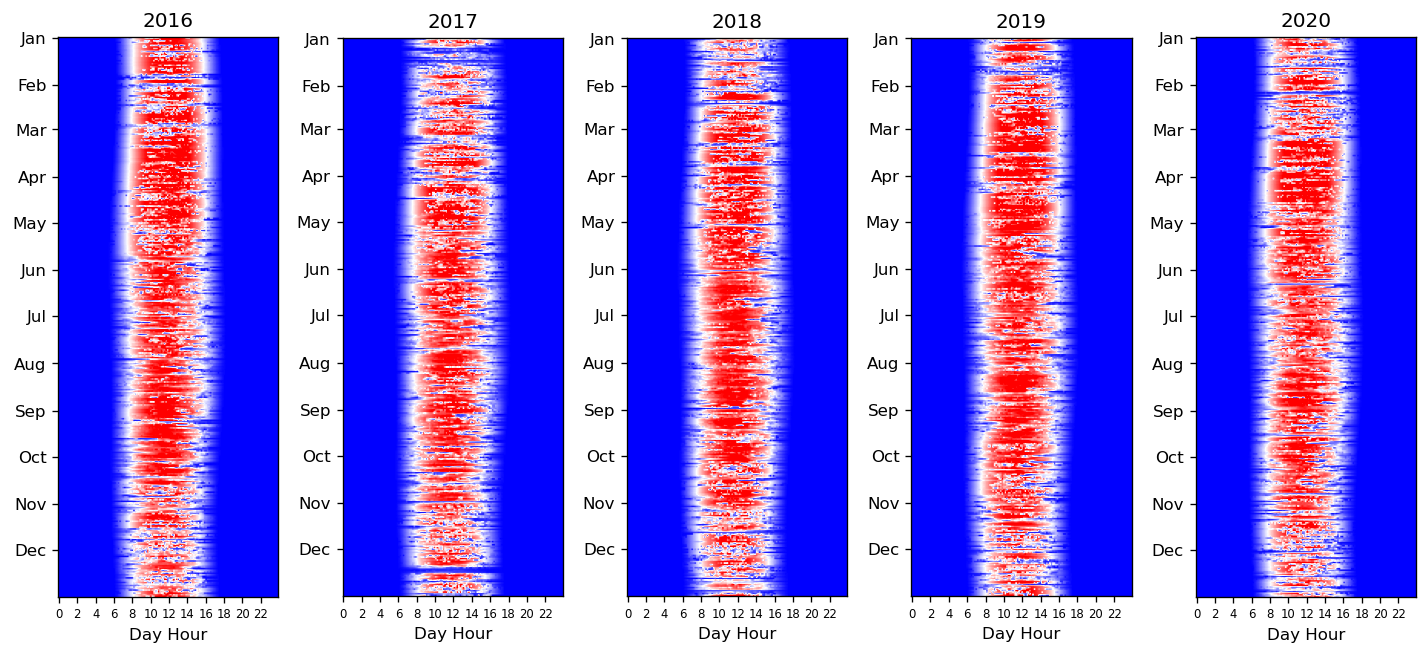

In [3]:
fig, axes = plt.subplots(1,5, figsize =(12,6), dpi=120)
ax = axes.flatten()
res = []
res_raw = []



for i in range(len(files)):
    file_path = os.path.join(path, files[i])
    cols = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI']
    df = pd.read_csv(file_path, skiprows=2, usecols = cols)
    df_hour_mean = df.groupby(['Year', 'Month', 'Hour']).mean().reset_index()
    df_year_long = df.pivot(index = ['Month', 'Day'], columns = ['Hour','Minute'], values = 'GHI')
    
    df_reset_index = df_year_long.reset_index().copy()
    month_start_index = []
    for j in range(1,13):
        ms_idx = df_reset_index.loc[df_reset_index['Month'] == j].index[0]
        month_start_index.append(ms_idx)
    
    ax[i].set_title(df.loc[0, 'Year'])
    ax[i].imshow(df_year_long, cmap='bwr', vmin = 0, vmax = 820) #1076
    ax[i].set_yticks(month_start_index)
    ax[i].set_yticklabels([x[0:3] for x in calendar.month_name[1:]])
    ax[i].set_xticks(np.arange(0,144,12))
    ax[i].set_xticklabels(np.arange(0,24,2), size = 7)
    ax[i].set_xlabel('Day Hour')
    pc_year_long = np.percentile(df_year_long.values, 95)
    #print(pc_year_long)
    res.append(df_year_long)
    res_raw.append(df)
plt.tight_layout()
plt.show()

df_all = pd.concat(res)
df_raw = pd.concat(res_raw)

/tmp/ipykernel_2392/1438900880.py:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_mean_all = df_all.reset_index().drop('Day_11', axis=1).groupby(['Month','Day']).mean().groupby('Minute_20', axis=1).mean()


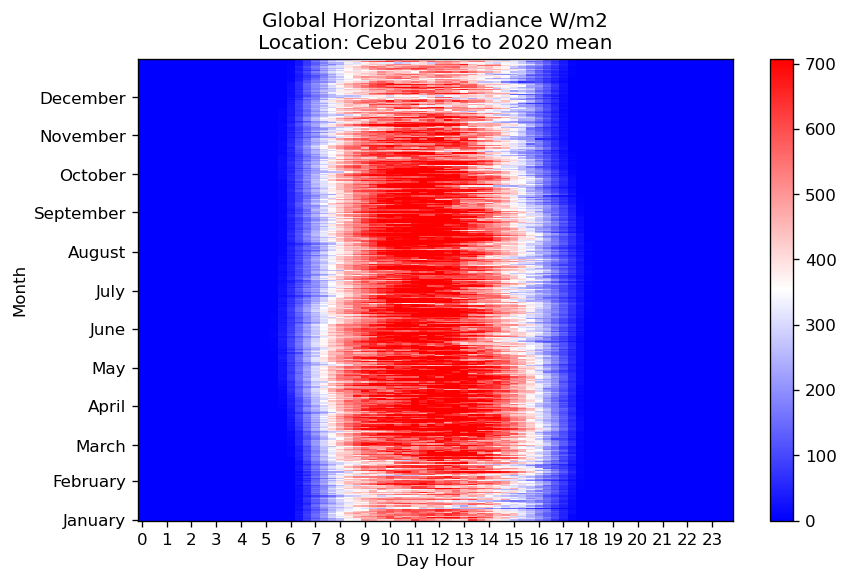

In [4]:
group_index = []
for tup in df_all.index:
    val = np.floor(tup[1]/11)*11
    group_index.append((tup[0], tup[1], val))
    
group_cols = []
for tup in df_all.columns:
    val = np.floor((tup[0]*60 + tup[1])/20)*20
    group_cols.append((tup[0], tup[1], val))
    
df_all.columns = pd.MultiIndex.from_tuples(group_cols, names = ['Hour', 'Minute_10', 'Minute_20'] )
df_all.index = pd.MultiIndex.from_tuples(group_index, names = ['Month', 'Day', 'Day_11'] )

df_mean_all = df_all.reset_index().drop('Day_11', axis=1).groupby(['Month','Day']).mean().groupby('Minute_20', axis=1).mean()

df_mean_all.drop((2,29), inplace=True)

mean_all_pc = np.percentile(df_mean_all.values, 95)

df_mean_all_ri = df_mean_all.reset_index()
month_start = []
for i in range(1,13):
    midx = df_mean_all_ri.reset_index().loc[df_mean_all_ri['Month'] == i].index[0]
    month_start.append(midx)
    
fig, ax = plt.subplots(figsize=(8,5), dpi=120)
pc = ax.pcolormesh(np.arange(72), np.arange(365), df_mean_all, cmap = 'bwr', vmin =0, vmax = mean_all_pc)
ax.set_yticks(month_start)
ax.set_yticklabels(calendar.month_name[1:])
ax.set_xticks(np.arange(0,72,3))
ax.set_xticklabels(np.arange(24))
ax.set_title('Global Horizontal Irradiance W/m2\nLocation: Cebu 2016 to 2020 mean')
ax.set_xlabel("Day Hour")
ax.set_ylabel("Month")
fig.colorbar(pc)
plt.show()

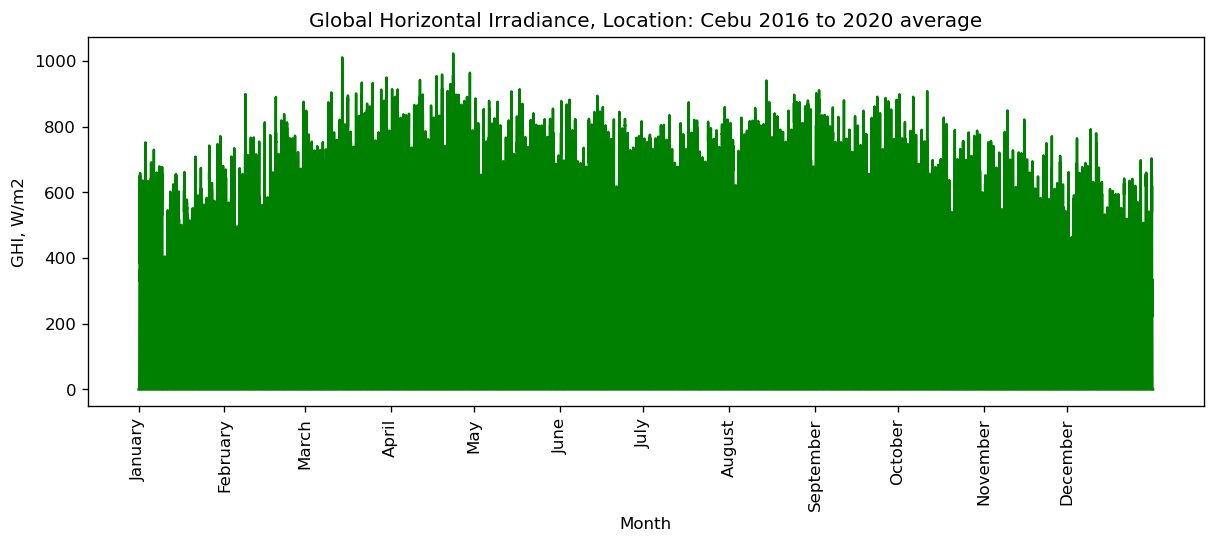

In [5]:
df_raw_pivot = df_raw.pivot(index = ['Month', 'Day', 'Hour', 'Minute'], columns = 'Year', values = 'GHI')
df_raw_mean = df_raw_pivot.mean(axis=1).to_frame('GHI')
df_raw_mean = df_raw_mean.reset_index()

month_start = []
for i in range(1,13):
    midx = df_raw_mean.loc[df_raw_mean['Month'] == i].index[0]
    month_start.append(midx)

fig, ax = plt.subplots(figsize=(12,4), dpi=120)
ax.plot(df_raw_mean['GHI'], color = 'green')
ax.set_xticks(month_start)
ax.set_xticklabels(calendar.month_name[1:], rotation = 90)
ax.set_xlabel("Month")
ax.set_ylabel("GHI, W/m2")
ax.set_title("Global Horizontal Irradiance, Location: Cebu 2016 to 2020 average")
plt.show()

# Electrical Consumption Profile

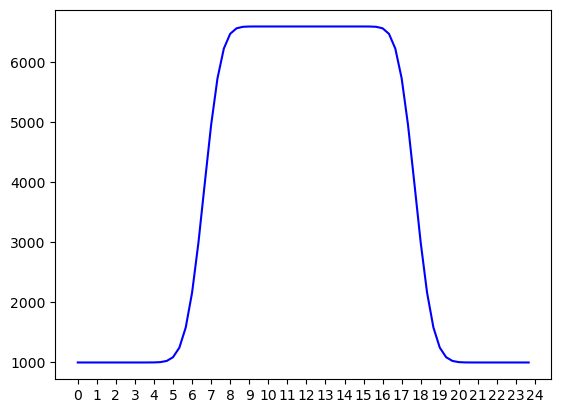

In [6]:
df_daily_power = pd.read_csv('/home/vboxuser/Data/Solar_Data/Electrical_Consumption/synth_daily_power.csv')

timestamp = df_daily_power['timestamp'].values
pow1 = df_daily_power['power_1'].values*4
pow2 = df_daily_power['power_2'].values*5600+1000

plt.plot(timestamp,pow2, color = 'blue')
plt.xticks(np.arange(25))
plt.show()

In [18]:
df_daily_power

,timestamp,power_1,power_2
0,0.000000,100.000000,0.000000e+00
1,0.333333,95.000000,0.000000e+00
2,0.666667,90.000000,0.000000e+00
3,1.000000,85.000000,0.000000e+00
4,1.333333,80.000000,0.000000e+00
...,...,...,...
67,22.333333,211.666667,9.354024e-17
68,22.666667,198.333333,0.000000e+00
69,23.000000,185.000000,0.000000e+00
70,23.333333,156.666667,0.000000e+00


In [7]:
def calc_pow_diff(cons_pow, solar_pow):
    diff = cons_pow - solar_pow
    if diff < 0:
        diff = 0
    return diff

def calc_surplus_power(cons_pow, solar_pow):
    diff = solar_pow - cons_pow
    if diff < 0:
        diff = 0
    return diff

Number of Solar Panel: 74 panels
Solar Panel Capacity: 25.1149964264 kWp
Panel Total Area: 161.1



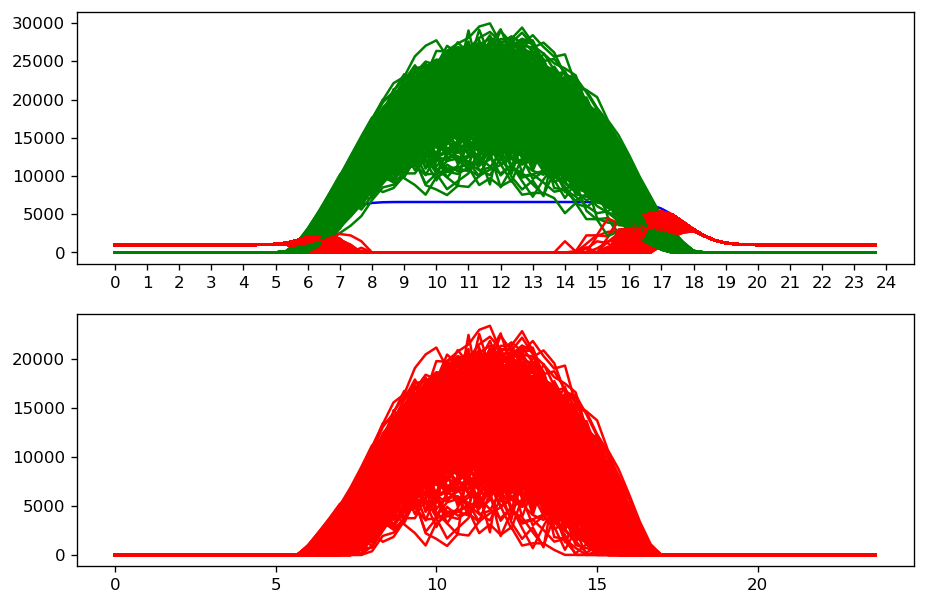

Solar Production at Current Year: 56815.6482621888
Monthly Electric Bill: 34182.341927322246
Yearly Electric Bill: 410188.103127867
Yearly Discounted Electric Bill: 91033.41546679454
Yearly Electric Bill Savings: 319154.6876610725
Yearly Electric Bill Net Metering: 186493.36274922054
Capacity Factor: 25.82442969939117 %


In [8]:
installed_capacity_kW = 25
panel_m2 = 2.176705
panel_efficiency = 0.1949
num_panels = int(np.ceil(installed_capacity_kW*1000/(panel_m2*panel_efficiency*800)))
electric_price = 13
net_metering_price = 5.78
solar_panel_capacity = num_panels*panel_m2*panel_efficiency*800
print(f'Number of Solar Panel: {num_panels} panels')
print(f'Solar Panel Capacity: {solar_panel_capacity/1000} kWp')
print(f'Panel Total Area: {np.round(num_panels*panel_m2,1)}')
print()
base_consumption = []
solar_production = []
discounted_consumption = []
surplus_energy = []
month_num = []
day_num = []

fig, axes = plt.subplots(2,1, figsize=(9,6), dpi=120)
ax = axes.flatten()
ax[0].plot(timestamp,pow2, color = 'blue')
for i in range(365):
    test_day = df_mean_all.iloc[i]
    month_num.append(test_day.name[0])
    day_num.append(test_day.name[1])
    
    solar_power_test_day = test_day*panel_m2*panel_efficiency*num_panels
    

    
    df_test = pd.DataFrame(np.column_stack([pow2, solar_power_test_day]), columns = ['consumption', 'solar_power'])
    df_test['solar_production'] = df_test['solar_power']*0.001*1/3
    df_test['power_diff'] = df_test.apply(lambda row: calc_pow_diff(row['consumption'],row['solar_power']), axis =1)
    df_test['consumption_kWh'] = df_test['consumption']*0.001*1/3
    df_test['disc_consumption_kWh'] = df_test['power_diff']*0.001*1/3
    df_test['surplus_power'] = df_test.apply(lambda row: calc_surplus_power(row['consumption'],row['solar_power']), axis =1)
    df_test['surplus_power_kWh'] = df_test['surplus_power']*0.001*1/3
    
    consump_kWh = np.sum(df_test['consumption_kWh'])
    solar_production_kWh = np.sum(df_test['solar_production'])
    solar_production.append(solar_production_kWh)
    discounted_consump_kWh = np.sum(df_test['disc_consumption_kWh'])
    base_consumption.append(consump_kWh)
    discounted_consumption.append(discounted_consump_kWh)
    surplus_power_kWh = np.sum(df_test['surplus_power_kWh'])
    surplus_energy.append(surplus_power_kWh)
    
    ax[0].plot(timestamp,solar_power_test_day, color = 'green')
    ax[0].plot(timestamp, df_test['power_diff'].values, color = 'red')
    ax[1].plot(timestamp, df_test['surplus_power'].values, color = 'red')

ax[0].set_xticks(np.arange(25))
#plt.ylim(0,1200)
plt.show()


df_year_data = pd.DataFrame(np.column_stack([month_num, 
                                             day_num,
                                             solar_production,
                                             base_consumption, 
                                             discounted_consumption, 
                                             surplus_energy]),
                                           columns = ['month', 
                                                      'day', 
                                                      'Solar_Production',
                                                      'base_kWh', 
                                                      'discounted_kWh', 
                                                      'surplus_kWh'])

df_year_data['base_price'] = df_year_data['base_kWh']*electric_price
df_year_data['discounted_price'] = df_year_data['discounted_kWh']*electric_price
df_year_data['savings_price'] = df_year_data['base_price'] - df_year_data['discounted_price']
df_year_data['surplus_price'] = df_year_data['surplus_kWh']*net_metering_price
df_year_data.loc[:, 'net_bill'] = df_year_data['discounted_price'] - df_year_data['surplus_price']

solar_production = np.sum(df_year_data['Solar_Production'])
electric_bill_yearly = np.sum(df_year_data['base_price'])
electric_bill_yearly_discounted = np.sum(df_year_data['discounted_price'])
electric_bill_yearly_surplus = np.sum(df_year_data['surplus_price'])

electric_bill_savings = np.sum(df_year_data['savings_price'])
print(f'Solar Production at Current Year: {solar_production}')
print(f'Monthly Electric Bill: {electric_bill_yearly/12}')
print(f'Yearly Electric Bill: {electric_bill_yearly}')
print(f'Yearly Discounted Electric Bill: {electric_bill_yearly_discounted}')
print(f'Yearly Electric Bill Savings: {electric_bill_savings}')
print(f'Yearly Electric Bill Net Metering: {electric_bill_yearly_surplus}')


capacity_factor = solar_production/(solar_panel_capacity*24*365*0.001)

print(f'Capacity Factor: {capacity_factor*100} %')

[]

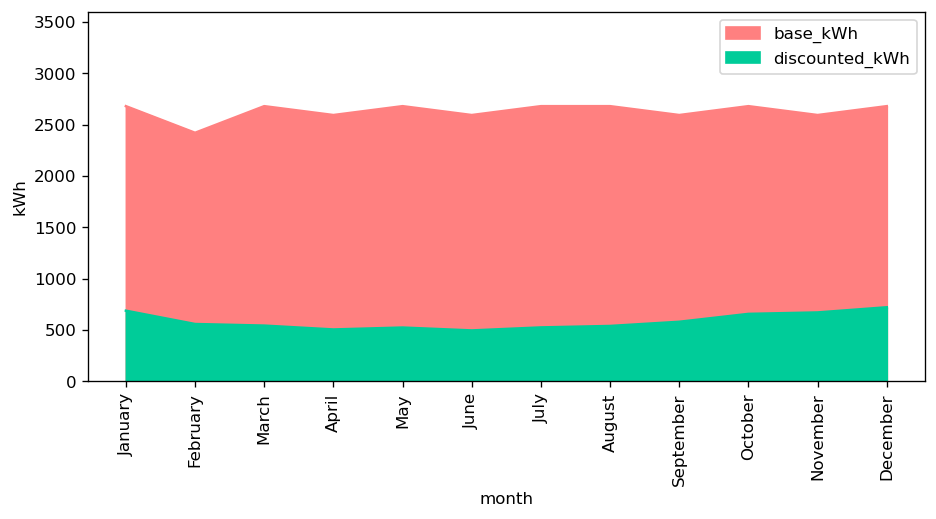

In [9]:
df_mm_sum = df_year_data.drop('day', axis = 1).groupby('month').sum()

fig, ax = plt.subplots(figsize=(9,4), dpi=120)
df_mm_sum[['base_kWh', 'discounted_kWh']].plot.area(stacked=False, ax=ax, alpha =1, color = ['#ff8080', '#00cc99'])
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(calendar.month_name[1:], rotation = 90)
ax.set_ylabel('kWh')
ax.legend(loc = 'upper right')
ax.set_ylim(0,3600)
plt.plot()

[]

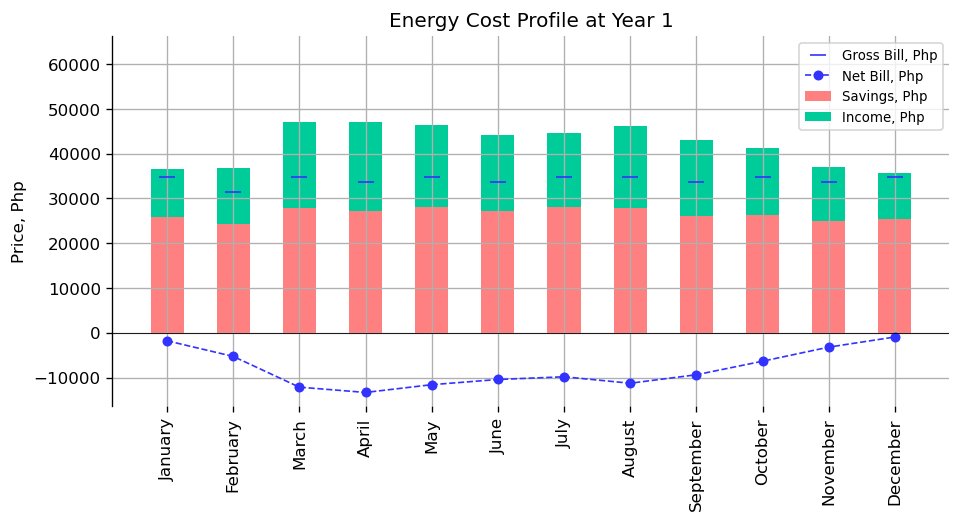

In [10]:
fig, ax = plt.subplots(figsize=(9,4), dpi=120)
ax.set_title("Energy Cost Profile at Year 1")
ax.grid()
y1 = df_mm_sum['savings_price']
y2 = df_mm_sum['surplus_price']
y3 = df_mm_sum['base_price']
y4 = df_mm_sum['net_bill']
ax.bar(df_mm_sum.index, y1, color = '#ff8080', width = 0.5, label = 'Savings, Php')
ax.bar(df_mm_sum.index, y2, bottom = y1, color = '#00cc99', width = 0.5, label = 'Income, Php')
ax.plot(df_mm_sum.index, y3, marker = '_', ms = 10,lw = 0, color = '#3333ff', label = 'Gross Bill, Php')
ax.plot(df_mm_sum.index, y4, marker ='o', ms = 5, ls = '--', lw = 1, color = '#3333ff', label = 'Net Bill, Php')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(calendar.month_name[1:], rotation = 90)
ax.set_ylabel('Price, Php')
ax.set_ylim(None,np.max(y3)*1.9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axhline(0, color = 'black', lw = 0.5)

ax.legend(loc = 'upper right', fontsize = 8)
plt.plot()

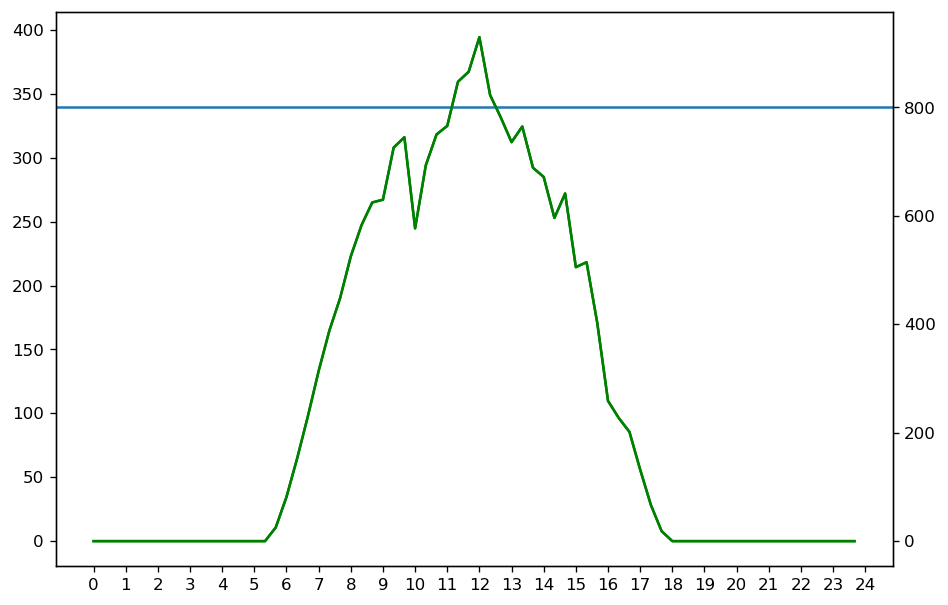

In [11]:
test = df_mean_all.loc[(4,22)]
test = df_mean_all.loc[(4,22)]
fig, ax = plt.subplots(figsize=(9,6), dpi=120)
ax.plot(timestamp,test*panel_m2*panel_efficiency, color = 'green')
ax.set_xticks(np.arange(25))
ax.axhline(339.4)
ax2 = ax.twinx()
ax2.plot(timestamp,test, color = 'green')
plt.show()

In [12]:
installed_capacity_kW = 60
panel_m2 = 2.176705
panel_efficiency = 0.1949
num_panels = int(np.ceil(installed_capacity_kW*1000/(panel_m2*panel_efficiency*800)))
electric_price = 13
net_metering_price = 5.78
solar_panel_capacity = num_panels*panel_m2*panel_efficiency*800
inverter_capacity = 10 #kWp
inverter_price_per_unit_y0 = 55000
inflation_factor = 0.01
inverter_price_per_unit_y10 = inverter_price_per_unit_y0*(1+inflation_factor)**10
inverter_price_per_unit_y20 = inverter_price_per_unit_y0*(1+inflation_factor)**20
inverter_count = int(np.ceil(solar_panel_capacity/1000/inverter_capacity))
inverter_total_price_y0 = inverter_price_per_unit_y0*inverter_count
inverter_total_price_y10 = inverter_price_per_unit_y10*inverter_count
inverter_total_price_y20 = inverter_price_per_unit_y20*inverter_count
reserve_y1_y9_per_year = inverter_total_price_y10/9
reserve_y11_y19_per_year = inverter_total_price_y20/9
reserve = [reserve_y1_y9_per_year]*9 +[0] + [reserve_y11_y19_per_year]*9 + [0,0,0,0,0,0]

panel_degradation_factor = 0.00658
consumption_increase_factor = 0.01
electric_price_inlfation = 0.01
power_day = pow2.copy()

price_per_panel = 10000
panel_total_price = num_panels*price_per_panel
overhead = 0.275
total_installed_cost = np.round((inverter_total_price_y0 + panel_total_price)*(1+overhead),2)

print(f'Number of Solar Panel: {num_panels} panels')
print(f'Number of Solar Inverter: {inverter_count} units @ {inverter_capacity} kWp')
print(f'Solar Panel Capacity: {solar_panel_capacity/1000} kWp')
print(f'Panel Total Area: {np.round(num_panels*panel_m2,1)} square meters')
print(f'Total Installed Cost: Php{total_installed_cost}')
print()

res = []

for y in tqdm(range(1,26)):
    base_consumption = []
    solar_production = []
    discounted_consumption = []
    surplus_energy = []
    month_num = []
    day_num = []
    for i in range(365):
        test_day = df_mean_all.iloc[i]
        month_num.append(test_day.name[0])
        day_num.append(test_day.name[1])
        
        solar_power_test_day = test_day*panel_m2*panel_efficiency*num_panels*(1-panel_degradation_factor)**y
        

        
        df_test = pd.DataFrame(np.column_stack([power_day, solar_power_test_day]), columns = ['consumption', 'solar_power'])
        df_test['solar_production'] = df_test['solar_power']*0.001*1/3
        df_test['power_diff'] = df_test.apply(lambda row: calc_pow_diff(row['consumption'],row['solar_power']), axis =1)
        df_test['consumption_kWh'] = df_test['consumption']*0.001*1/3
        df_test['disc_consumption_kWh'] = df_test['power_diff']*0.001*1/3
        df_test['surplus_power'] = df_test.apply(lambda row: calc_surplus_power(row['consumption'],row['solar_power']), axis =1)
        df_test['surplus_power_kWh'] = df_test['surplus_power']*0.001*1/3
        
        consump_kWh = np.sum(df_test['consumption_kWh'])
        solar_production_kWh = np.sum(df_test['solar_production'])
        solar_production.append(solar_production_kWh)
        discounted_consump_kWh = np.sum(df_test['disc_consumption_kWh'])
        base_consumption.append(consump_kWh)
        discounted_consumption.append(discounted_consump_kWh)
        surplus_power_kWh = np.sum(df_test['surplus_power_kWh'])
        surplus_energy.append(surplus_power_kWh)
        


    df_year_data = pd.DataFrame(np.column_stack([month_num, 
                                                day_num,
                                                solar_production,
                                                base_consumption, 
                                                discounted_consumption, 
                                                surplus_energy]),
                                            columns = ['month', 
                                                        'day', 
                                                        'Solar_Production',
                                                        'base_kWh', 
                                                        'discounted_kWh', 
                                                        'surplus_kWh'])

    df_year_data['base_price'] = df_year_data['base_kWh']*electric_price
    df_year_data['discounted_price'] = df_year_data['discounted_kWh']*electric_price
    df_year_data['savings_price'] = df_year_data['base_price'] - df_year_data['discounted_price']
    df_year_data['surplus_price'] = df_year_data['surplus_kWh']*net_metering_price
    df_year_data.loc[:, 'net_bill'] = df_year_data['discounted_price'] - df_year_data['surplus_price']

    production = np.sum(df_year_data['Solar_Production'])
    consumption = np.sum(df_year_data['base_kWh'])
    surplus = np.sum(df_year_data['surplus_kWh'])
    gross_bill = np.sum(df_year_data['base_price'])
    bill_discounted = np.sum(df_year_data['discounted_price'])
    bill_surplus = np.sum(df_year_data['surplus_price'])
    net_bill = np.sum(df_year_data['net_bill'])
    bill_savings = np.sum(df_year_data['savings_price'])
    

    power_day = power_day*(1+consumption_increase_factor)
    electric_price = electric_price*(1+electric_price_inlfation)

    res.append([y, production, consumption, surplus, gross_bill, bill_discounted, bill_savings, bill_surplus, net_bill])

df_res = pd.DataFrame(res, columns = ['year', 'production', 'consumption', 'surplus', 'gross_bill', 'discounted_bill', 'cash_savings', 'revenue', 'net_bill'])
df_res['reserves'] = reserve
df_res['total_benefit'] = df_res['cash_savings'] + df_res['net_bill']*-1 - df_res['reserves']
df_res['cumulative_benefit'] = df_res['total_benefit'].cumsum() - total_installed_cost
df_res['cumulative_benefit'] = df_res['cumulative_benefit'].apply(lambda x: np.round(x,1))

df_res['cash_flow'] = df_res['net_bill']*-1 - df_res['reserves']
df_res['cum_cash_flow'] = df_res['cash_flow'].cumsum() - total_installed_cost
df_res['cum_cash_flow'] = df_res['cum_cash_flow'].apply(lambda x: np.round(x,1))

Number of Solar Panel: 177 panels
Number of Solar Inverter: 7 units @ 10 kWp
Solar Panel Capacity: 60.0723563172 kWp
Panel Total Area: 385.3 square meters
Total Installed Cost: Php2747625.0



100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [01:07<00:00,  2.70s/it]


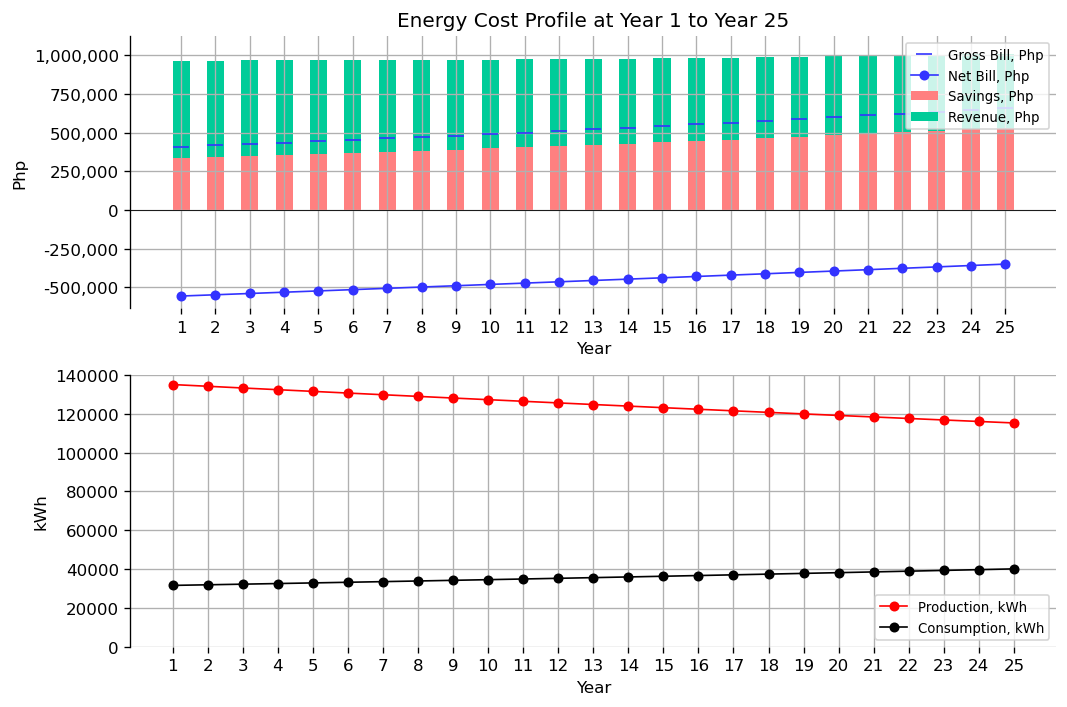

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(9,6), dpi=120)
ax = axes.flatten()
ax[0].set_title("Energy Cost Profile at Year 1 to Year 25")
ax[0].grid()
ax[0].ticklabel_format(style='plain')

y1 = df_res['cash_savings']
y2 = df_res['revenue']
y3 = df_res['gross_bill']
y4 = df_res['net_bill']
y5 = df_res['production']
y6 = df_res['consumption']
yr = df_res['year']

ax[0].bar(yr, y1, color = '#ff8080', width = 0.5, label = 'Savings, Php')
ax[0].bar(yr, y2, bottom = y1, color = '#00cc99', width = 0.5, label = 'Revenue, Php')
ax[0].plot(yr, y3, marker = '_', ms = 10,lw = 0, color = '#3333ff', label = 'Gross Bill, Php')
ax[0].plot(yr, y4, marker ='o', ms = 5, ls = '-', lw = 1, color = '#3333ff', label = 'Net Bill, Php')
ax[0].set_xticks(np.arange(1,26))
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Php')
ax[0].set_ylim(None,np.max(y3)*1.7)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].axhline(0, color = 'black', lw = 0.5)
ax[0].legend(loc = 'upper right', fontsize = 8)
ax[0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[1].grid()
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].plot(yr, y5, marker ='o', ms = 5, lw = 1, color = 'red', label = 'Production, kWh')
ax[1].plot(yr, y6, marker ='o', ms = 5, lw = 1, color = 'black', label = 'Consumption, kWh')
ax[1].set_ylim(0, None)
ax[1].set_xticks(np.arange(1,26))
ax[1].set_xlabel('Year')
ax[1].set_ylabel('kWh')
ax[1].legend(loc = 'lower right', fontsize = 8)
plt.tight_layout()
plt.show()

In [14]:
df_res

,year,production,consumption,surplus,gross_bill,discounted_bill,cash_savings,revenue,net_bill,reserves,total_benefit,cumulative_benefit,cash_flow,cum_cash_flow
0,1,135002.686885,31552.931010,109296.493238,410188.103128,76007.585712,334180.517416,631733.730914,-555726.145203,47253.279809,842653.382809,-1904971.6,508472.865393,-2239152.1
1,2,134114.369205,31868.460320,108164.860704,418432.884001,77715.837377,340717.046624,625192.894869,-547477.057492,47253.279809,840940.824307,-1064030.8,500223.777683,-1738928.4
2,3,133231.896656,32187.144923,107036.934222,426843.384969,79464.129636,347379.255333,618673.479800,-539209.350165,47253.279809,839335.325689,-224695.5,491956.070355,-1246972.3
3,4,132355.230776,32509.016372,105912.758207,435422.937007,81254.759916,354168.177091,612175.742438,-530920.982523,47253.279809,837835.879805,613140.4,483667.702713,-763304.6
4,5,131484.333358,32834.106536,104792.407068,444174.938041,83090.506137,361084.431904,605700.112856,-522609.606719,47253.279809,836440.758813,1449581.2,475356.326910,-287948.3
5,6,130619.166444,33162.447601,103675.707366,453102.854295,84970.852718,368132.001577,599245.588578,-514274.735859,47253.279809,835153.457627,2284734.6,467021.456050,179073.2
6,7,129759.692329,33494.072077,102562.484174,462210.221667,86895.223213,375314.998454,592811.158526,-505915.935313,47253.279809,833977.653958,3118712.3,458662.655504,637735.9
7,8,128905.873553,33829.012798,101452.557116,471500.647122,88862.923010,382637.724112,586395.780128,-497532.857118,47253.279809,832917.301420,3951629.6,450279.577308,1088015.4
8,9,128057.672905,34167.302926,100345.981978,480977.810129,90876.535638,390101.274492,579999.775830,-489123.240192,47253.279809,831971.234875,4783600.8,441869.960383,1529885.4
9,10,127215.053418,34508.975955,99242.854585,490645.464113,92939.299315,397706.164798,573623.699503,-480684.400188,0.000000,878390.564986,5661991.4,480684.400188,2010569.8


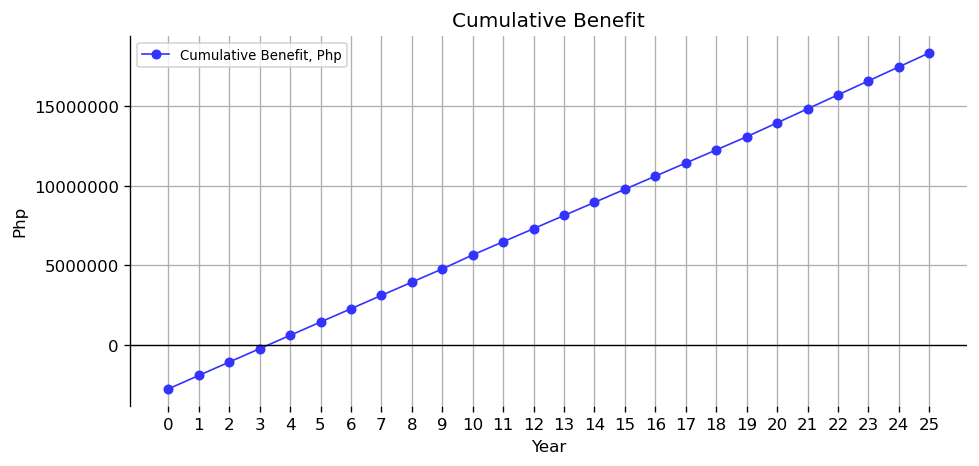

In [15]:
fig, ax = plt.subplots(figsize=(9,4), dpi=120)
ax.set_title("Cumulative Benefit")
ax.grid()


ax.plot([0] + list(df_res['year']), [-total_installed_cost]+list(df_res['cumulative_benefit']), marker ='o', ms = 5, ls = '-', lw = 1, color = '#3333ff', label = 'Cumulative Benefit, Php')
ax.set_xticks(np.arange(0,26))
#ax.set_xticklabels(calendar.month_name[1:], rotation = 90)
ax.set_xlabel('Year')
ax.set_ylabel('Php')
#ax.set_ylim(None,np.max(y3)*1.9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axhline(0, color = 'black', lw = 0.8)
ax.legend(loc = 'upper left', fontsize = 8)
plt.ticklabel_format(style='plain')
plt.show()

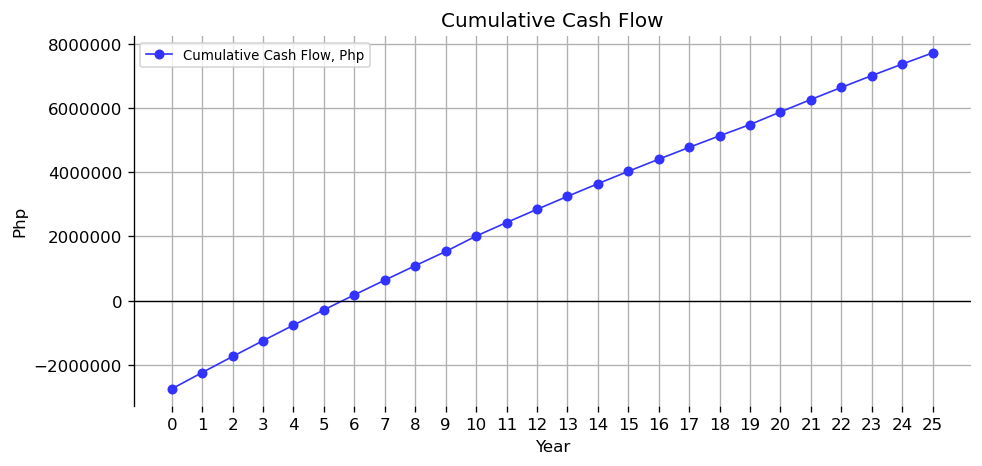

In [16]:
fig, ax = plt.subplots(figsize=(9,4), dpi=120)
ax.set_title("Cumulative Cash Flow")
ax.grid()


ax.plot([0] + list(df_res['year']), [-total_installed_cost]+list(df_res['cum_cash_flow']), marker ='o', ms = 5, ls = '-', lw = 1, color = '#3333ff', label = 'Cumulative Cash Flow, Php')
ax.set_xticks(np.arange(0,26))
#ax.set_xticklabels(calendar.month_name[1:], rotation = 90)
ax.set_xlabel('Year')
ax.set_ylabel('Php')
#ax.set_ylim(None,np.max(y3)*1.9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axhline(0, color = 'black', lw = 0.8)
ax.legend(loc = 'upper left', fontsize = 8)
plt.ticklabel_format(style='plain')
plt.show()

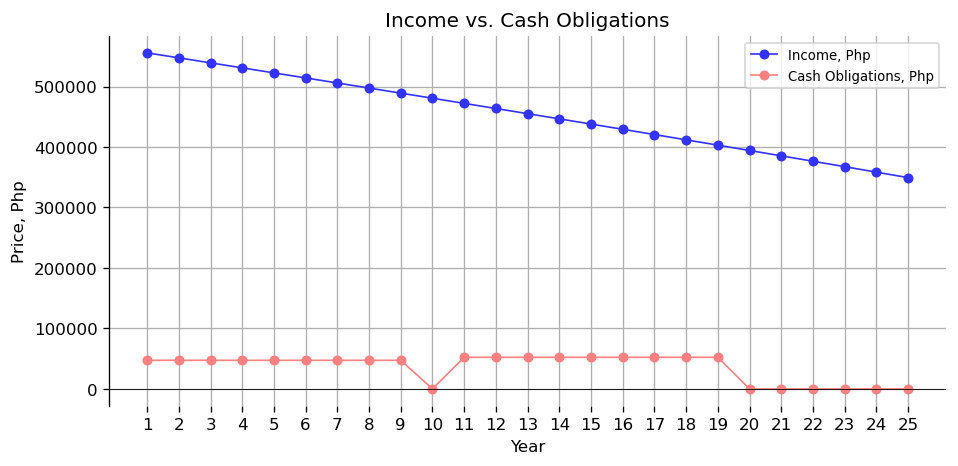

In [17]:
fig, ax = plt.subplots(figsize=(9,4), dpi=120)
ax.set_title("Income vs. Cash Obligations")
ax.grid()


ax.plot(df_res['year'], df_res['net_bill']*-1, marker ='o', ms = 5, ls = '-', lw = 1, color = '#3333ff', label = 'Income, Php')
ax.plot(df_res['year'], df_res['reserves'], marker ='o', ms = 5, ls = '-', lw = 1, color = '#ff8080', label = 'Cash Obligations, Php')
ax.set_xticks(np.arange(1,26))
ax.set_xlabel('Year')
ax.set_ylabel('Price, Php')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axhline(0, color = 'black', lw = 0.5)
ax.legend(loc = 'upper right', fontsize = 8)
plt.show()